<a href="https://colab.research.google.com/github/Pathairush/index_alert/blob/main/Bollinger_bands.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install yfinance -q

: 

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import datetime

# Module

In [17]:
from operator import xor
class BollinergerBands():

    def __init__(self, rolling_period: int, stddev_boundary: int):
        
        self.rolling_period = rolling_period
        self.stddev_boundary = stddev_boundary
        self.fitted_data = None

    @staticmethod
    def _get_column_name(X: pd.DataFrame) -> list:
        X.columns = [c.lower() for c in X.columns]
        return X.columns.tolist()

    def _check_required_columns(self, X: pd.DataFrame):
        
        input_column_names = self._get_column_name(X)
        required_columns = ['date', 'high', 'low', 'close']
        for col in required_columns:
            if col not in input_column_names:
                raise ValueError(f"Expect: {required_columns}, Found: {input_column_names}")
        return True

    def _check_minimum_period(self):

        pass

    def _preprocess_data(self, data: pd.DataFrame):

        # calculate typical price
        data.loc[:, 'typical_price'] = (data['high'] + data['low'] + data['close']) / 3

        # calculate simple moving average
        data.loc[:, f'sma_{self.rolling_period}'] = data['typical_price'].rolling(self.rolling_period).mean()
        data.loc[:, f'std_{self.rolling_period}'] = data['typical_price'].rolling(self.rolling_period).std()

        # calculate bollinger bands
        data.loc[:, 'bolu'] = data[f'sma_{self.rolling_period}'] + self.stddev_boundary * data[f'std_{self.rolling_period}']
        data.loc[:, 'bold'] = data[f'sma_{self.rolling_period}'] - self.stddev_boundary * data[f'std_{self.rolling_period}']

        # use T-1 day bollinger band as a trigger criteria
        data.loc[:, 'bolu_yesterday'] = data['bolu'].shift(1)
        data.loc[:, 'bold_yesterday'] = data['bold'].shift(1)

        # drop rows doesn't have enough data point the rolling period
        data = data[data[f'sma_{self.rolling_period}'].notna()].copy()

        # calculate historical trigger (day)
        data.loc[:, 'trigger'] = np.where(~data['close'].between(data['bold_yesterday'], data['bolu_yesterday']), 1, 0)
        data.loc[:, 'trigger_bolu'] = np.where(data['close'] > data['bolu_yesterday'], 1, 0)
        data.loc[:, 'trigger_bold'] = np.where(data['close'] < data['bold_yesterday'], 1, 0)

        # calculate percent change of index
        data.loc[:, 'close_yesterday'] = data['close'].shift(1)
        data.loc[:, 'pct_index_change'] = ((data['close'] / data['close_yesterday']) - 1) * 100

        # calcualte year month for notificaiton reports
        data.loc[:, 'year'] = data['date'].dt.year
        data.loc[:, 'year_month'] = data['date'].dt.strftime("%Y-%m")

        self.fitted_data = data

        return data

    def fit(self, X: pd.DataFrame):

        assert self._check_required_columns(X) == True

        X = self._preprocess_data(X)

        self.bold = float(X.tail(1)['bold'].values)
        self.bolu = float(X.tail(1)['bolu'].values)

    def plot_bollinger_bands(self):
        
        if self.fitted_data is None:
            raise ValueError('Fitted data is not found, please call `fit` method')
        
        (
            self.fitted_data
            .loc[:, ['date','typical_price','bolu','bold']]
            .set_index('date')
            .plot.line(figsize=(9,6))
        );

    def plot_number_of_notifications(self, resolution: str, trigger_name: str):
        '''
        Plot number of notification ['trigger', 'trigger_bolu', 'trigger_bold'] by resolution ['year', 'year_month']
        '''
        
        expect_resolution = ['year', 'year_month']
        expect_trigger_name = ['trigger', 'trigger_bolu', 'trigger_bold']
        
        if resolution not in expect_resolution:
            raise ValueError(f'resolution should be in {expect_resolution}, found : {resolution}')
        
        if trigger_name not in expect_trigger_name:
            raise ValueError(f'trigger_name should be in {expect_resolution}, found : {resolution}')

        self.fitted_data.groupby(resolution).agg({trigger_name:'sum'}).plot.bar(figsize=(12,6))

# Back test report

In [18]:
index = yf.Ticker('^HSI')
data = index.history(period='5y').reset_index()

# input
model = BollinergerBands(rolling_period = 365, stddev_boundary = 2)
model.fit(X = data)

In [4]:
model.bold

20998.90651709035

In [5]:
model.bolu

31199.12786504435

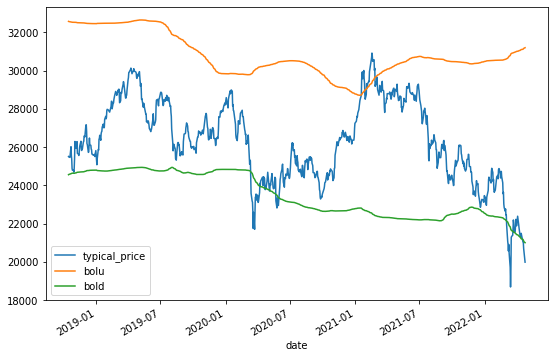

In [8]:
model.plot_bollinger_bands()

In [9]:
data = model.fitted_data

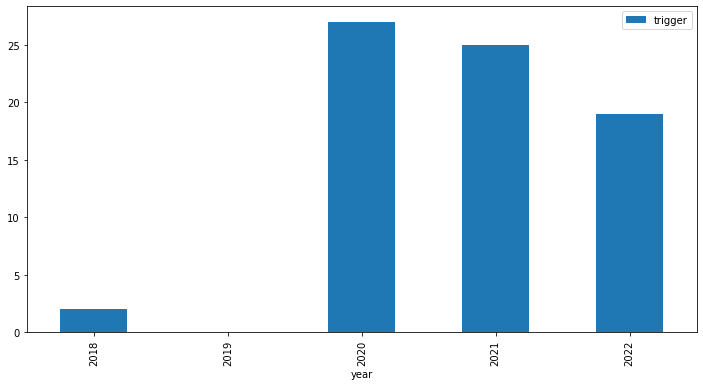

In [19]:
# number of trigger per year
model.plot_number_of_notifications(resolution = 'year', trigger_name = 'trigger')

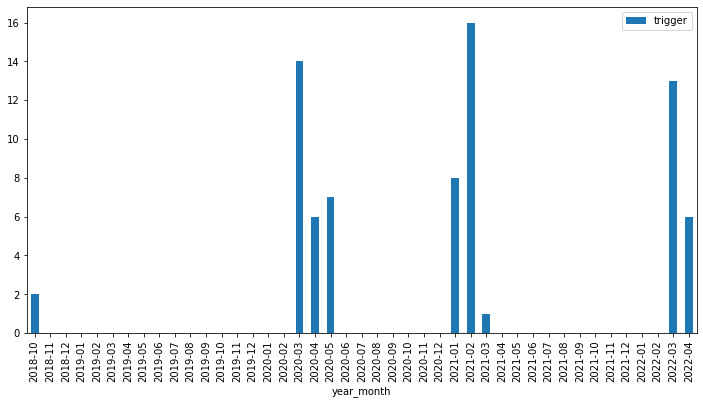

In [20]:
# overall trigger
model.plot_number_of_notifications(resolution = 'year_month', trigger_name = 'trigger')

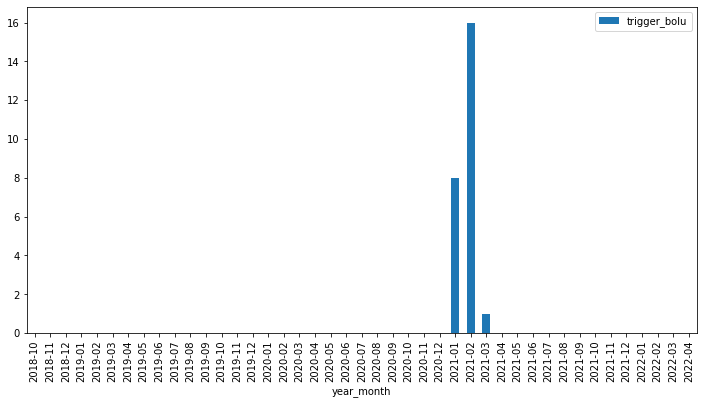

In [21]:
# upside trigger
model.plot_number_of_notifications(resolution = 'year_month', trigger_name = 'trigger_bolu')

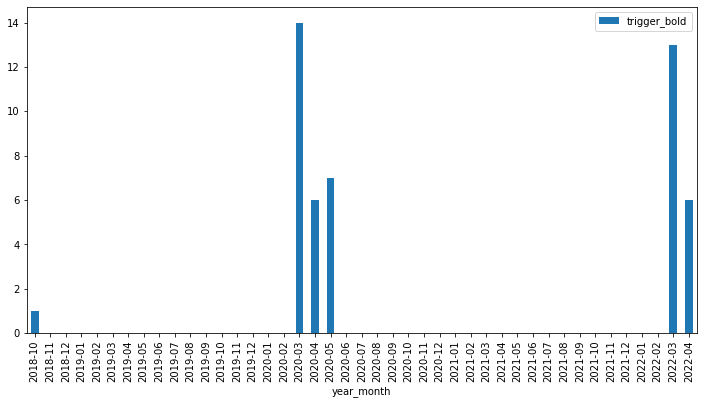

In [22]:
# drawdown trigger
model.plot_number_of_notifications(resolution = 'year_month', trigger_name = 'trigger_bold')

# Bollinger bands behavior

- all closing price in that day will compare to [`bold_yesterday`, `bolu_yesterday`] boundary.
- `bold_yesterday` and `bolu_yesterday` would be update at the end of the day. (market close time + 1hr).
- request data for market open / close time to use in the scheduling pipeline.

In [14]:
data.head()

,date,open,high,low,close,volume,dividends,stock splits,typical_price,sma_365,...,bold,bolu_yesterday,bold_yesterday,trigger,trigger_bolu,trigger_bold,close_yesterday,pct_index_change,year,year_month
364,2018-10-15,25683.589844,25683.589844,25399.539062,25445.060547,1614888500,0,0,25509.396484,28565.446106,...,24554.819160,NaN,NaN,1,0,0,NaN,NaN,2018,2018-10
365,2018-10-16,25586.160156,25712.130859,25266.539062,25462.259766,1467251700,0,0,25480.309896,28568.484591,...,24568.937614,32576.073053,24554.819160,0,0,0,25445.060547,0.067594,2018,2018-10
366,2018-10-18,25674.660156,25674.660156,25261.720703,25454.550781,1764725000,0,0,25463.643880,28570.913287,...,24580.020484,32568.031568,24568.937614,0,0,0,25462.259766,-0.030276,2018,2018-10
367,2018-10-19,25172.029297,25743.449219,25090.300781,25561.400391,2037871700,0,0,25465.050130,28573.218411,...,24590.506732,32561.806089,24580.020484,0,0,0,25454.550781,0.419766,2018,2018-10
368,2018-10-22,25668.330078,26234.859375,25668.330078,26153.150391,2222812200,0,0,26018.779948,28577.036137,...,24606.851715,32555.930091,24590.506732,0,0,0,25561.400391,2.315014,2018,2018-10


In [16]:
data[['date','close','pct_index_change','bold_yesterday', 'bolu_yesterday','trigger', 'trigger_bold', 'trigger_bolu']].tail(20)

,date,close,pct_index_change,bold_yesterday,bolu_yesterday,trigger,trigger_bold,trigger_bolu
1213,2022-03-24,21945.949219,-0.939470,21572.901312,30935.260147,0,0,0
1214,2022-03-25,21404.880859,-2.465459,21557.942424,30942.810633,1,1,0
1215,2022-03-28,21684.970703,1.308533,21535.247729,30954.600872,0,0,0
1216,2022-03-29,21927.630859,1.119025,21510.296867,30967.126057,0,0,0
1217,2022-03-30,22232.029297,1.388196,21488.509142,30977.514952,0,0,0
1218,2022-03-31,21996.849609,-1.057842,21469.761926,30985.787225,0,0,0
1219,2022-04-01,22039.550781,0.194124,21448.934788,30995.112957,0,0,0
1220,2022-04-04,22502.310547,2.099679,21425.809172,31005.663088,0,0,0
1221,2022-04-06,22080.519531,-1.874434,21406.462972,31013.321050,0,0,0
1222,2022-04-07,21808.980469,-1.229768,21383.098893,31022.741293,0,0,0


?: Do we need to assign logic for consecutive trigger interm of day